## Image Captioning With MS Coco Dataset
In this project, we use ResNet50 and LSTM to design and train a convolutional neural network + recurrent neural network model to automatically generate image captions. The encoder will be CNN, which will extract image features, and the decoder will be RNN, which will model language up to the word level. The network is trained on the MS COCO (Microsoft Common Objects in Context) dataset.



In [1]:
!pip install pycocotools
!pip install scikit-image
!pip install nltk
!pip install pycocoevalcap
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 7.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 94.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 kB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 36.5 MB/s eta 0:00:0000:0100:01
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 86.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 144.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [14]:
# Import modules
import mlflow
import mlflow.pytorch
from mlflow.models.signature import infer_signature
import os
import sys
sys.path.append('/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from datetime import datetime
import psutil
from PIL import Image
import json
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Set the tracking URI to the MLflow server
mlflow.set_tracking_uri("http://195.201.225.177:5000")

In [4]:
mlflow.set_experiment("MSCOCO Image Captioning Exp")



<Experiment: artifact_location='s3://mlops-ic-demo/artifacts/9', creation_time=1728868825782, experiment_id='9', last_update_time=1728868825782, lifecycle_stage='active', name='MSCOCO Image Captioning Exp', tags={}>

## Visualize the dataset

To visualize the data, we begin by initializing the COCO API that you will use to obtain the data which is the images and the annotations. Then, we'll plot a random image from the dataset, along with its five corresponding captions. Each time you run the code cell below, a different image is selected.

In the project, we will use this dataset to train our own model to generate captions from images.

In [15]:
# initialize COCO API for instance annotations
datasetDir = '../coco'
datasetType = 'val2017'
instances_annFile = os.path.join(datasetDir, 'annotations/instances_{}.json'.format(datasetType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(datasetDir, 'annotations/captions_{}.json'.format(datasetType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


http://images.cocodataset.org/val2017/000000333745.jpg


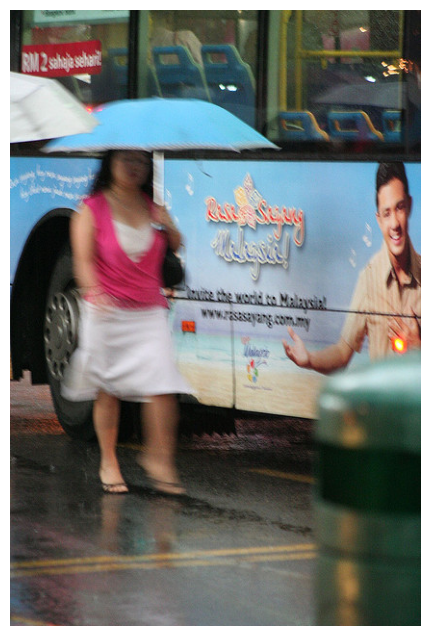

A woman with an umbrella is walking past a bus.
A woman holding an umbrella walks past the side of a bus with a large advertisement on the side. 
Woman walking next to commuter bus with umbrella on rainy day.
a woman walking down the sidewalk next to a bus
A woman holding an umbrella and walking beside a bus.


In [16]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id'])
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [17]:
import sys
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
from dataLoader import get_loader
from torchvision import transforms
import torch.utils.data as data

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Training Setup

We will customize the training of our CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values we set now will be used when training our model. 

We begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend `num_epochs=5`. [Xu et al., 2016](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but we'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if we want our model to compete with current research, we will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that we **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  We have to keep this at its default value of `100` to avoid clogging the notebook
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

In [18]:
# Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [19]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

# Import EncoderCNN and DecoderRNN. 
from model import EncoderCNN, DecoderRNN
import math
# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())

# Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

# Set the total number of training steps per epoch.
total_step = 10#math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.11s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:54<00:00, 10878.76it/s]


In [10]:
from pycocoevalcap.eval import COCOEvalCap
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
# from json import encoder
# encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [11]:
def clean_sentence(output):
    list_string = []
    
    for idx in output:
        list_string.append(data_loader.dataset.vocab.idx2word[idx])
    
    list_string = list_string[1:-1] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence

def log_metrices():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print("1")
    # Specify the saved models to load.
    encoder_file = 'encoder-3.pkl' 
    decoder_file = 'decoder-3.pkl'

    # Select appropriate values for the Python variables below.
    embed_size = 512
    hidden_size = 512

    # The size of the vocabulary.
    vocab_size = len(data_loader.dataset.vocab)

    # Initialize the encoder and decoder, and set each to inference mode.
    encoder = EncoderCNN(embed_size)
    encoder.eval()
    decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
    decoder.eval()

    # Load the trained weights.
    encoder.load_state_dict(torch.load(os.path.join('./models/', encoder_file), map_location=torch.device('cpu')))
    decoder.load_state_dict(torch.load(os.path.join('./models/', decoder_file), map_location=torch.device('cpu')))

    # Move models to GPU if CUDA is available.
    encoder.to(device)
    decoder.to(device)
    #print("2")
    
    # Define a transform to pre-process the test images.
    transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                         transforms.ToTensor(), \
                                         transforms.Normalize((0.485, 0.456, 0.406), \
                                                              (0.229, 0.224, 0.225))])

    # # Obtain the data loader.
    # data_loader = get_loader(transform=transform_train,
    #                          mode='test',
    #                          batch_size=1)
    

    # Evaluate the validation set using the above metrics
    img_ids = []
    count = 0
    json_dumps = []
    while count < 10: 
        # Load a random image from val2017
        cocoapi_loc='../coco'
        img_folder = os.path.join(cocoapi_loc, 'images/val2017/')
        ann_id = np.random.choice(ids)
        img_id = coco.anns[ann_id]['image_id']
        print("2.1")
        if img_id in img_ids:
            continue
        else:
            img_ids.append(img_id)
            img = coco.loadImgs(img_id)[0]
            path = coco.loadImgs(img_id)[0]['file_name']
            image = Image.open(os.path.join(img_folder, path)).convert('RGB')
            annIds = coco_caps.getAnnIds(imgIds=img['id'])
            anns = coco_caps.loadAnns(annIds)
            #print("2.2")
            # Load the caption of the image
            captions = [anns[i]['caption'].split() for i in range(len(anns))] 
            # transform image to tensor
            image = transform_test(image)
            # change tensor to 4D
            image = torch.reshape(image, (1,3,224,224))
            # Feed tensor to the encoder and decoder
            image = image.to(device)      
            #print("2.3")
            features = encoder(image).unsqueeze(1)
            output = decoder.sample(features)
            # Get predicted caption
            sentence = clean_sentence(output)
            json_dumps.append({"image_id": img_id, "caption": sentence}) 
            count += 1
            #print("2.4")
                 
    val_json = json.dumps(json_dumps)
    #print("3")
    # Write generated captions to json file 
    with open('validation_captions.json', 'w') as outfile:
        outfile.write(val_json)
    
    resFile = "validation_captions.json"
    #coco = COCO(annFile)
    cocoRes = coco.loadRes(resFile)
    
    # create cocoEval object by taking coco and cocoRes
    cocoEval = COCOEvalCap(coco_caps, cocoRes)
    #print("4")
    # evaluate on a subset of images by setting
    # cocoEval.params['image_id'] = cocoRes.getImgIds()
    # please remove this line when evaluating the full validation set
    cocoEval.params['image_id'] = cocoRes.getImgIds()

    # evaluate results
    cocoEval.evaluate()
    #print("5")
    # print output evaluation scores
    for metric, score in cocoEval.eval.items():
        print( '%s: %.3f'%(metric, score))
        mlflow.log_metric(metric, score)
    

In [12]:
import mlflow.pyfunc
import shutil
import os

class ImageCaptioningPyFuncModel(mlflow.pyfunc.PythonModel):
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder

    def load_context(self, context):
        

        # Access the paths of artifacts via context.artifacts
        vocab_path = context.artifacts["vocab"]
        captions_dir = context.artifacts["captions"]
        
        print(f"vocab_path: {vocab_path}")
        print(f"captions_dir: {captions_dir}")

        # Get the current working directory
        current_working_dir = os.getcwd()

        # Print current working directory for debugging (optional)
        print(f"Current working directory: {current_working_dir}")

        # Copy the vocab file to the current working directory
        target_vocab_path = os.path.join(current_working_dir, "vocab.pkl")
        if not os.path.exists(target_vocab_path):
            shutil.copy(vocab_path, target_vocab_path)
        else:
            print(f"File {target_vocab_path} already exists, skipping copy.")

        # Copy the captions directory to the current working directory
        target_captions_dir = os.path.join(current_working_dir, "image_info_test2017.json")
        if os.path.exists(target_captions_dir):
            print(f"Directory {target_captions_dir} already exists, skipping copy.")
        else:
            shutil.copy(captions_dir, target_captions_dir)
        
        # Ensure models are on the correct device (e.g., CPU or GPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder.to(self.device)
        self.decoder.to(self.device)
        
        transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                         transforms.ToTensor(), \
                                         transforms.Normalize((0.485, 0.456, 0.406), \
                                                              (0.229, 0.224, 0.225))])

        # Load the data loader to access vocabulary for captioning
        self.data_loader  = get_loader(transform=transform_test,
                             mode='test',
                             batch_size=1,
                             vocab_threshold=vocab_threshold,
                             vocab_from_file=vocab_from_file)
        self.vocab = self.data_loader.dataset.vocab  # Access the vocabulary

    def predict(self, context, model_input):
        # Model input should be a dictionary containing the preprocessed image
        print('model_input', model_input)
        image = model_input["instances"][0]  # This should be a list (or numpy array) of the preprocessed image
        #print("image type", typ(image))

        # Convert input to a PyTorch tensor (if it's a list or numpy array)
        image_tensor = torch.tensor(image, dtype=torch.float32).to(self.device)

        # Ensure that the image tensor has the correct shape (add batch dimension if missing)
        if image_tensor.ndimension() == 3:  # If missing batch dimension (CxHxW)
            image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension (BxCxHxW)
        
        print("image.shape: ", image_tensor.shape)

        # Now pass the image tensor through the encoder
        features = self.encoder(image_tensor)
        print("features.shape: ", features.shape)
        
        if features.ndimension() == 2:
            features = features.unsqueeze(0)  # Add batch dimension (1, feature_size)
        print("features.shape1: ", features.shape)
        # Pass the features through the decoder to generate the caption
        caption = self.decoder.sample(features)

        # Convert generated caption (list of integers) to text
        sentence = self.clean_sentence(caption)
    
        return sentence

    def clean_sentence(self, output):
        """Convert list of integers (word indices) to a readable sentence."""
        if not isinstance(output, list):
            output = output.tolist()  # Ensure output is a list

        list_string = []
        for idx in output:
            # Check if idx is valid (avoid non-integer values)
            if isinstance(idx, int):
                list_string.append(self.vocab.idx2word[idx])

        # Discard <start> and <end> tokens
        list_string = list_string[1:-1]  
        return ' '.join(list_string).capitalize()


## Train the model

In [20]:
# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"ResNet50_LSTM_bs{batch_size}_lr{optimizer.param_groups[0]['lr']}_epochs{num_epochs}_{timestamp}"

mlflow.enable_system_metrics_logging()
#mlflow.pytorch.autolog()

# Model Architecture Metadata Example
model_architecture = {
    "encoder_layers": len(list(encoder.parameters())),
    "decoder_layers": len(list(decoder.parameters())),
    "embedding_size": embed_size,
    "hidden_size": hidden_size
}

with mlflow.start_run(run_name=run_name):
    
    # Log the dataset metadata
    num_images = len(ids)
    mlflow.log_param("num_images", num_images)
    mlflow.log_artifact(instances_annFile, artifact_path="datasets/annotations")
    mlflow.log_artifact(captions_annFile, artifact_path="datasets/annotations")

    
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("training step", total_step)
    mlflow.log_param("vocab_threshold", vocab_threshold)
    mlflow.log_param("embed_size", embed_size)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("encoder", "ResNet50")
    mlflow.log_param("decoder", "LSTM")
    
    #Log model architecture details
    mlflow.log_dict(model_architecture, "model_architecture.json")
        
    for epoch in range(1, num_epochs+1):

        for i_step in range(1, total_step+1):

            if time.time() - old_time > 60:
                old_time = time.time()

            # Randomly sample a caption length, and sample indices with that length.
            indices = data_loader.dataset.get_train_indices()
            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            data_loader.batch_sampler.sampler = new_sampler

            # Obtain the batch.
            images, captions = next(iter(data_loader))

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)

            # Zero the gradients.
            decoder.zero_grad()
            encoder.zero_grad()

            # Pass the inputs through the CNN-RNN model.
            features = encoder(images)
            outputs = decoder(features, captions)

            # Calculate the batch loss.
    #         print("outputs.shape: ", outputs.shape)
            loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))

            # Backward pass.
            loss.backward()
            
            # Log loss and perplexity for each epoch
            mlflow.log_metric("train_loss", loss.item(), step=epoch)
            mlflow.log_metric("train_perplexity", np.exp(loss.item()), step=epoch)

            # Update the parameters in the optimizer.
            optimizer.step()

            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))

            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()

            # Print training statistics (on different line).
            if i_step % print_every == 0:
                print('\r' + stats)
                mlflow.log_param("stats per epoch", stats)
            

        # Save the weights.
        if epoch % save_every == 0:
            torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
            torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))
            
        
            #mlflow.pytorch.log_model(encoder, "encoder")
            #mlflow.pytorch.log_model(decoder, "decoder")
            mlflow.pyfunc.log_model(
            #infer_code_paths=True,
            artifact_path="image_captioning_pyfunc_model",
            code_paths=["dataLoader.py", "model.py","vocabulary.py"],
            pip_requirements="requirements.txt",
            artifacts={
            "vocab": "vocab.pkl",
            "captions": "image_info_test2017.json"
            },
            python_model=ImageCaptioningPyFuncModel(encoder, decoder)
            )
            
            
    log_metrices()
        
# Close the training log file.
f.close()

2024/10/21 08:51:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: Driver Not Loaded.
2024/10/21 08:51:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch [1/3], Step [10/10], Loss: 5.3738, Perplexity: 215.6772

2024/10/21 08:52:55 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.2.0, required: torch==2.4.1)
 - torchvision (current: 0.17.0, required: torchvision==0.19.1)
 - pycocotools (current: 2.0.8, required: pycocotools==2.0)
 - Cython (current: uninstalled, required: Cython==3.0.11)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/10/21 08:52:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch [2/3], Step [10/10], Loss: 5.2243, Perplexity: 185.7315

2024/10/21 08:54:24 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.2.0, required: torch==2.4.1)
 - torchvision (current: 0.17.0, required: torchvision==0.19.1)
 - pycocotools (current: 2.0.8, required: pycocotools==2.0)
 - Cython (current: uninstalled, required: Cython==3.0.11)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/10/21 08:54:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch [3/3], Step [10/10], Loss: 4.5845, Perplexity: 97.9498

2024/10/21 08:55:49 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.2.0, required: torch==2.4.1)
 - torchvision (current: 0.17.0, required: torchvision==0.19.1)
 - pycocotools (current: 2.0.8, required: pycocotools==2.0)
 - Cython (current: uninstalled, required: Cython==3.0.11)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/10/21 08:55:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2.1
2.1
2.1
2.1
2.1
2.1
2.1
2.1
2.1
2.1
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 609 tokens at 6557.78 tokens per second.
PTBTokenizer tokenized 59 tokens at 453.20 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 40, 'reflen': 86, 'guess': [40, 30, 20, 10], 'correct': [27, 5, 0, 0]}
ratio: 0.4651162790643591
Bleu_1: 0.214
Bleu_2: 0.106
Bleu_3: 0.000
Bleu_4: 0.000
computing METEOR score...
METEOR: 0.058
computing Rouge score...
ROUGE_L: 0.303
computing CIDEr score...
CIDEr: 0.044
computing SPICE score...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classif

SPICE evaluation took: 8.089 s
SPICE: 0.023
Bleu_1: 0.214
Bleu_2: 0.106
Bleu_3: 0.000
Bleu_4: 0.000
METEOR: 0.058
ROUGE_L: 0.303
CIDEr: 0.044
SPICE: 0.023


2024/10/21 08:56:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run ResNet50_LSTM_bs32_lr0.001_epochs3_20241021_085121 at: http://195.201.225.177:5000/#/experiments/9/runs/ab541e18ae074c4a9a1259dadc9271d7.
2024/10/21 08:56:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://195.201.225.177:5000/#/experiments/9.
2024/10/21 08:56:18 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/21 08:56:18 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


## Model Register

In [ ]:
from mlflow import MlflowClient

if True:  # Only register if BLEU score is above 0.7
    # Register the model in the Model Registry
    client = MlflowClient()
    model_uri="s3://mlops-ic-demo/artifacts/8/e321eb8f1a6c4c90afe0b3d82f6e02bb/artifacts/decoder"
    run_id="runs:/e321eb8f1a6c4c90afe0b3d82f6e02bb/decoder"
    model_name = "Image_Captioning_Decoder"
    model_version = 51
    # model_version = client.create_model_version(
    #     name=model_name,
    #     version=model_version
    # )
    
    # Add metadata to the model version
    client.update_model_version(
        name=model_name,
        version=model_version,
        description=f"Model with BLEU score: {val_bleu_score}, architecture: {model_architecture}"
    )
    
    # Optionally, add tags for additional metadata
    client.set_model_version_tag(
        name=model_name,
        version=model_version.version,
        key="embedding_size",
        value=model_architecture["embedding_size"]
    )
    
    client.set_model_version_tag(
        name=model_name,
        version=model_version.version,
        key="num_layers",
        value=model_architecture["num_layers"]
    )
    
    print(f"Model registered as version {model_version.version}")
else:
    print("Model not registered due to insufficient performance.")

## Deployement

In [ ]:
from mlflow.deployments import get_deploy_client

config = dict(
    #assume_role_arn="arn:aws:iam::517064449064:role/sagemaker-assume-role",
    execution_role_arn="arn:aws:iam::517064449064:role/SageMakerExecutionRole",
    bucket_name="my-s3-bucket",
    image_url="517064449064.dkr.ecr.us-west-2.amazonaws.com/encoder:2.16.2",
    region_name="us-west-2",
    archive=False,
    instance_type="ml.m5.large",
    instance_count=1,
    synchronous=True,
    timeout_seconds=300,
    #vpc_config=vpc_config,
    variant_name="prod-variant-1",
    env={"DISABLE_NGINX": "true", "GUNICORN_CMD_ARGS": '"--timeout 60"'},
    tags={"training_timestamp": "2022-11-01T05:12:26"},
)
client = get_deploy_client("sagemaker")
client.create_deployment(
    "my-deployment",
    model_uri="s3://mlops-ic-demo/artifacts/8/f2ad8bbe5c69490182a49165f860fed8/artifacts/encoder",
    flavor="python_function",
    config=config,
)